In [18]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F

# define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Download and load training data
trainset = datasets.FashionMNIST(
    'data/FASHION_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load test data
testset = datasets.FashionMNIST(
    'data/FASHION_MNIST_data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)



In [36]:
# Create the network, define criterion and optimizer
from torch import nn, optim

input_units = 784
hidden_units = [256, 128, 64]
output_units = 10

model = nn.Sequential(
    nn.Linear(input_units, hidden_units[0]),
    nn.ReLU(),
    nn.Linear(hidden_units[0], hidden_units[1]),
    nn.ReLU(),
    nn.Linear(hidden_units[1], hidden_units[2]),
    nn.ReLU(),
    nn.Linear(hidden_units[2], output_units),
    nn.LogSoftmax(dim=1)
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
epochs= 5

In [37]:
# Train the network
for i in range(epochs):
    running_loss = 0
    for images, target_labels in trainloader:
        # flatten images into 784 long vector for the input layer
        images = images.view(images.shape[0], -1)
        # clear gradients because they accumulate
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, target_labels)
        # let optmizer update the parameters
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f'Training loss: {running_loss/len(trainloader)}')

Training loss: 0.5213481309666816
Training loss: 0.3745512448664286
Training loss: 0.33560746372032013
Training loss: 0.3119227885723368
Training loss: 0.29549156429607476


In [67]:
import matplotlib.pyplot as plt
import numpy as np

def view_classification(img, probabilities):
    """Utility to imshow the image and its predicted classes."""
    ps = probabilities.data.numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels([
        'T-shirt/top',
        'Trouser',
        'Pullover',
        'Dress',
        'Coat',
        'Sandal',
        'Shirt',
        'Sneaker',
        'Bag',
        'Ankle Boot'
    ], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()          

torch.Size([64, 10])


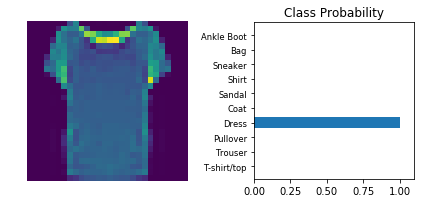

In [80]:
# Test out the network
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]
# reshape images to the model input layer's liking.
test_images = images.view(images.shape[0], -1)
# Calculate class probabilities (softmax)
ps = torch.exp(model(test_images))
print(ps.shape)

# plot out the image and probability distribution
view_classification(img, ps[0])

#### Validation
To test for overfitting, we measure the performance of the model on data that isn't part of the training set.
We'll use accuracy, the percentage of classes the NN predicted correctly.
Other options are `precision and recall and top-5 error rate`.

First, we do one forward pass with one batch from the test set

In [85]:
images, labels = next(iter(testloader))
# get class probabilities (10 class probabilities for 64 examples)
images = images.view(images.shape[0], -1)
ps = torch.exp(model(images))
ps.shape

torch.Size([64, 10])

With the probabilities, we can use `ps.topk` to get the most likely class and return the `k` highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of top-k values and top-k indices. If the highest values is the 5th element, we'll get back 4 as the index.

In [92]:
top_p, top_class = ps.topk(1, dim=1)
print(top_class.shape)
print (labels.shape)


torch.Size([64, 1])
torch.Size([64])


In [96]:
# check where our predicted classes match with true classes from labels
equals = top_class == labels.view(*top_class.shape) # make sure they have the same shape
# convert the equals byte tensor into float tensor before doing the mean
accuracy = torch.mean(equals.type(torch.FloatTensor)) 
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 89.0625%


In [ ]:
# Train the network
epochs = 30
steps = 0

train_losses, test_losses = [], []
for i in range(epochs):
    running_loss = 0
    for images, target_labels in trainloader:
        # flatten images into 784 long vector for the input layer
        images = images.view(images.shape[0], -1)
        # clear gradients because they accumulate
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, target_labels)
        # let optmizer update the parameters
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        accuracy = 0
        test_loss = 0
        
        # turn off gradients for validation, saves memory and computation
        with torch.no_grad():
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                _, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print(f'Accuracy: {accuracy/len(testloader)}')
        print(f'Training loss: {running_loss/len(trainloader)}')
        print(f'Test loss: {test_loss/len(testloader)}')  

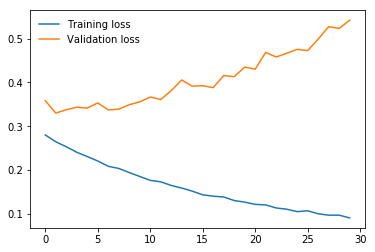

In [112]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

As the network gets better and better on the training data, it's actually starting to get worse on the test/validation data.
This is because as it's learning, it's failing to generalize to data outside of that.
This is the overfitting phenomenon at work.

We should always strive to get the lowest validation loss possible. 
* Early stopping – use version of the model with the lowest validation loss (8-10 training epochs)
* Dropout – give a drop probability, randomly drop input units, forcing the network to share imformation between weights, increasing it's ability to generalize to new data.


## Network with Dropout
During training we want to prevent overfitting using dropout. But during inference, we want to use all of our units. So we turn off the dropout using `mode.eval()`: which sets the model to evaluation mode. After calculating the validation loss and metric, we set the model back to train mode using `model.train()`

In [117]:
from torch import nn

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))        
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [ ]:
# Initialize the network
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 7
steps = 0
train_losses, test_losses = [], []

for i in range(epochs):
    running_loss = 0
    for images, target_labels in trainloader:
        # clear gradients because they accumulate
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, target_labels)
        # let optmizer update the parameters
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        accuracy = 0
        test_loss = 0
        
        # turn off gradients for validation, saves memory and computation
        with torch.no_grad():
            # set model to eval mode
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                _, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # set model back to train mode
        model.train() 
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print(f'Training loss: {running_loss/len(trainloader)}')
        print(f'Test loss: {test_loss/len(testloader)}')
        print(f'Accuracy: {accuracy/len(testloader)}')

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)